In [5]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
import sklearn.tree
%matplotlib inline 

## Load in data

In [6]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/dumble_8020_df.csv',index_col=0)

In [7]:
data.head(5)

Previous_10_Left_Choice  Previous_10_Right_Choice  Previous_10_Left_Reward  \
0                     10.0                       0.0                      8.0   
1                     10.0                       0.0                      7.0   
2                      9.0                       1.0                      6.0   
3                      8.0                       2.0                      5.0   
4                      8.0                       2.0                      5.0   

   Previous_10_Right_Reward  Streak  5_Port  5_Reward  5_ITI  5_trialDuration  \
0                       0.0    -1.0     1.0       0.0  3.286            0.407   
1                       0.0    -2.0     1.0       1.0  2.405            0.463   
2                       0.0    -3.0     1.0       1.0  2.379            0.367   
3                       0.0    -4.0     1.0       1.0  2.234            0.325   
4                       0.0     1.0     1.0       0.0  2.133            0.482   

   4_Port    ...     2_Reward  2_ITI  2_trialDuration  1_Port  1_Reward  \
0     1.0    ...          1.0  2.234            0.325     1.0       0.0   
1     1.0    ...          0.0  2.133            0.482     1.0       0.0   
2     1.0    ...          0.0  1.411            0.435     0.0       0.0   
3     1.0    ...          0.0  2.169            0.395     0.0       0.0   
4     1.0    ...          0.0  3.838            0.469     1.0       1.0   

   1_ITI  1_trialDuration  0_ITI  0_trialDuration  Decision  
0  2.133            0.482  1.411            0.435       1.0  
1  1.411            0.435  2.169            0.395       0.0  
2  2.169            0.395  3.838            0.469       0.0  
3  3.838            0.469  1.846            0.378       1.0  
4  1.846            0.378  1.527            0.416       1.0  

[5 rows x 28 columns]

In [8]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

# Change 'y' so that 1 corresponds to a switch, and 0 corresponds to no switch

In [9]:
y_diff = np.diff(y)
x = x[:-1,:]
y = np.abs(y_diff.copy())

print(x.shape)
print(y_diff.shape)

(5861, 27)
(5861,)


In [10]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

In [11]:
print('# train trials: %.0f | # switches: %.0f --> %.01f percent' % (y_train.shape[0],np.sum(y_train),np.sum(y_train)*100.0/y_train.shape[0]))
print('# test trials: %.0f | # switches: %.0f --> %.01f percent' % (y_test.shape[0],np.sum(y_test),np.sum(y_test)*100.0/y_test.shape[0]))

# train trials: 4102 | # switches: 362 --> 8.8 percent
# test trials: 1759 | # switches: 159 --> 9.0 percent


In [12]:
logreg = sklearn.linear_model.LogisticRegression()
logreg.fit(x_train,y_train)
y_predict = logreg.predict(x_test)
acc,F1=sf.score_F1_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         1600.0            0.0
True YES         158.0            1.0

F1: 0.013

Score: 0.91


# LDA and tune priors

In [13]:
'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

//anaconda/envs/ac209/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


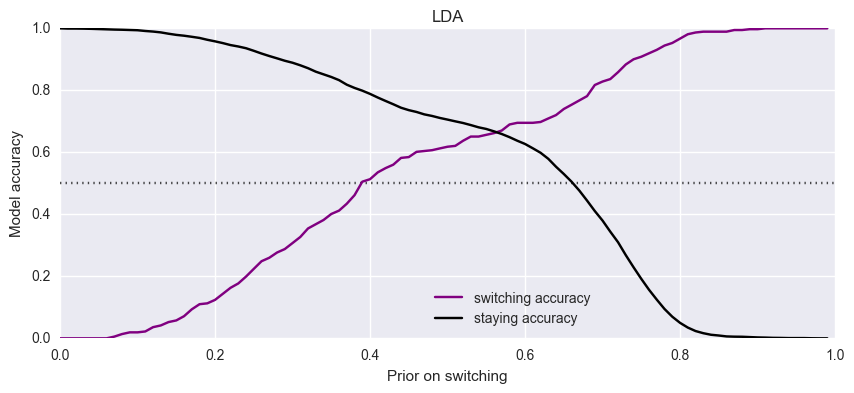

In [14]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA')

Cool - this is way better with more data. With 1 session of data, the two lines crossed just below 50%. Now we are doing well above chance!

## LDA with tuned prior parameters

In [15]:
best_lda = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.45,0.55])
best_lda.fit(x_train,y_train)
y_predict = best_lda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)


          Predicted NO  Predicted YES
True NO         1103.0          497.0
True YES          56.0          103.0

F1: 0.271

Accuracy on class 0: 0.69
Accuracy on class 1: 0.65



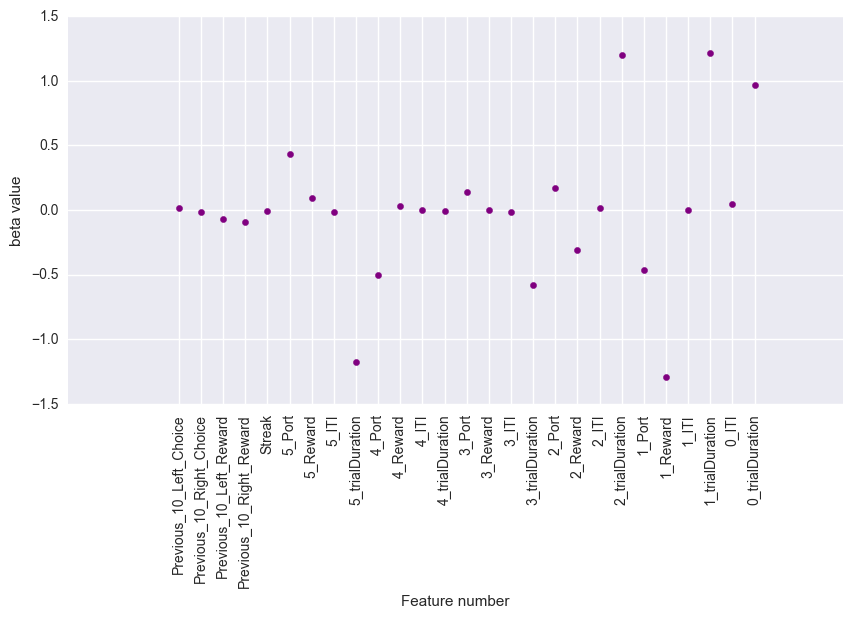

In [22]:
coefs = best_lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),data.columns.values,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

## Decision Tree

In [16]:
tree = Tree.DecisionTreeClassifier()
tree.fit(x_train,y_train)
y_predict = tree.predict(x_test)
acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         1445.0          155.0
True YES         141.0           18.0

F1: 0.108

Accuracy on class 0: 0.90
Accuracy on class 1: 0.11



## Decision Tree: tune depth & class weights

In [17]:
D = np.array([2,5,10,20,50,100])
P = np.arange(0,1,0.01)

acc_cv = []

for i,d in enumerate(D):
    
    for p in P:
        prior = np.array([1.0-p,p])
        tree = Tree.DecisionTreeClassifier(max_depth=d,class_weight={0:prior[0],1:prior[1]})

        kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
        cum_acc_pos = 0
        cum_acc_neg = 0

        for train_index,test_index in kf:
            x_train_cv = x_train[train_index,:]
            y_train_cv = y_train[train_index]
            x_test_cv = x_train[test_index,:]
            y_test_cv = y_train[test_index]

            tree.fit(x_train_cv,y_train_cv)
            y_predict = tree.predict(x_test_cv)

            acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

            cum_acc_pos += acc_pos
            cum_acc_neg += acc_neg

        acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)
    

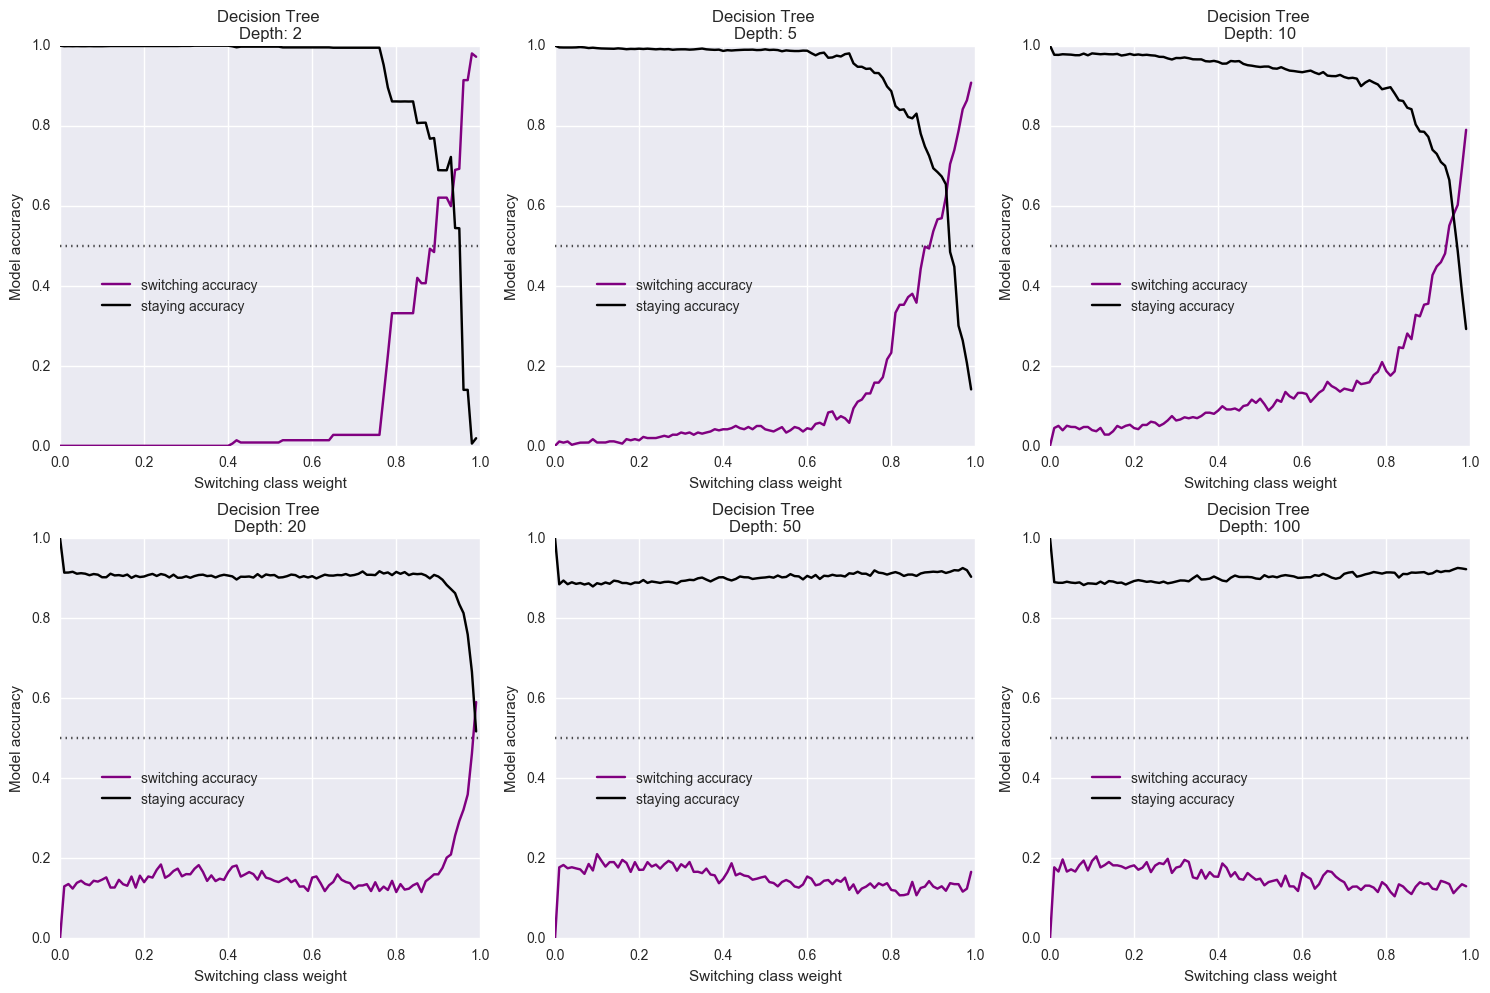

In [18]:
inds = np.arange(0,600,100)
plt.figure(figsize=(15,10))

for i,ind in enumerate(inds):
    
    plt.subplot(2,3,i+1)
    plt.plot(P,acc_cv[ind:ind+100,0],color='purple',label='switching accuracy')
    plt.plot(P,acc_cv[ind:ind+100,1],color='black',label='staying accuracy')
    plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
    plt.legend(loc='lower right',bbox_to_anchor=[0.5,0.3])
    plt.ylabel('Model accuracy')
    plt.xlabel('Switching class weight')
    plt.title('Decision Tree \nDepth: %.0f' % D[i])
plt.tight_layout()